# <center> Annual and Monthly MEF Comparisons </center> 

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
LABELS_ORDERED = ['co2_kg', 'co2_dam',
                  'so2_kg', 'so2_dam_ap2', 'so2_dam_eas',
                  'nox_kg', 'nox_dam_ap2', 'nox_dam_eas',
                  'pm25_kg', 'pm25_dam_ap2', 'pm25_dam_eas']
AP2_DAMS = ['co2_dam', 'so2_dam_ap2', 'nox_dam_ap2', 'pm25_dam_ap2']
EAS_DAMS = ['co2_dam', 'so2_dam_eas', 'nox_dam_eas', 'pm25_dam_eas']
FULL_DAMS = ['dam_ap2', 'dam_eas']
LABELS_EMISSIONS = ['co2_kg', 'so2_kg', 'nox_kg', 'pm25_kg']
LABELS_FULL = LABELS_ORDERED + FULL_DAMS

In [3]:
GROUPING_NAMES = ['SeasonalTOD', 'MonthTOD', 'TOD', 'YearOnly', 'Month']
GROUPING_COLS = [['year', 'season', 'hour'], ['year', 'month', 'hour'], 
        ['year', 'hour'], ['year'], ['year', 'month']]
GROUPING_NAMES_COLS = dict(zip(GROUPING_NAMES, GROUPING_COLS))

## Read in data 

In [4]:
def get_factor_df(kind='MEF', time='MonthTOD', region='PJM', fuel_type='FossilOnly'):
    kind_folder = 'mefs' if kind=='MEF' else 'aefs'
    
    # Read in file
    if fuel_type == 'FossilOnly':
        region_breakdown = 'isorto' if region == 'PJM' else 'nerc'
        df = pd.read_csv(os.path.join(os.pardir, 'calculated_factors', kind_folder, time, 
                                      '{}_{}.csv'.format(region_breakdown, kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        df = df[df[region_breakdown] == region].drop(region_breakdown, axis=1)
    else:
        if region != 'PJM':
            raise NotImplementedError('fossil-plus factors are only available for PJM')
        df = pd.read_csv(os.path.join(os.pardir, 'calculated_factors', kind_folder, time, 
                                      'pjm_fplus_{}.csv'.format(kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        
    # Filter MEF columns
    if kind == 'MEF':
        df = df.drop([x for x in df.columns if '-r' in x or '-int' in x], axis=1)
        df.columns = [x.replace('-est', '') for x in df.columns]
        
    # Ensure columns have numeric type
    df = df.apply(pd.to_numeric, axis=1)
    
    return df

In [5]:
all_dfs = {}
for kind in ['MEF', 'AEF']:
    for region in ['PJM', 'RFC']:
        for fuel_type in ['FossilOnly', 'FossilPlus']:
            for time in ['YearOnly', 'Month']:
                if region == 'RFC' and fuel_type == 'FossilPlus': 
                    continue
                print(kind, region, fuel_type, time)
                df = get_factor_df(kind=kind, time=time, region=region, fuel_type=fuel_type)
                all_dfs[(kind, region, fuel_type, time)] = df
                print(df.index.get_level_values('year').unique().values)    

MEF PJM FossilOnly YearOnly
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
MEF PJM FossilOnly Month
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
MEF PJM FossilPlus YearOnly
[2016 2017]
MEF PJM FossilPlus Month
[2016 2017]
MEF RFC FossilOnly YearOnly
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
MEF RFC FossilOnly Month
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
AEF PJM FossilOnly YearOnly
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
AEF PJM FossilOnly Month
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
AEF PJM FossilPlus YearOnly
[2016 2017]
AEF PJM FossilPlus Month
[2016 2017]
AEF RFC FossilOnly YearOnly
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
AEF RFC FossilOnly Month
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


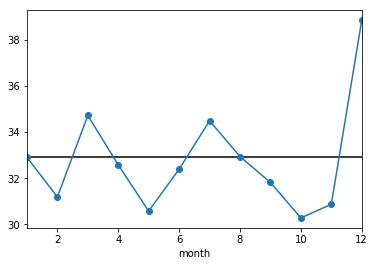

In [6]:
fig, ax = plt.subplots()
all_dfs[('AEF', 'PJM', 'FossilPlus', 'Month')].loc[2017, 'dam_ap2'].plot(ax=ax, style='o-')
plt.hlines(all_dfs[('AEF', 'PJM', 'FossilPlus', 'YearOnly')].loc[2017, 'dam_ap2'], 1, 12)

## Plotting MEFs

In [7]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

In [8]:
def format_title(label):
    l = label.split('_')
    if label in FULL_DAMS:
        t = 'Total damages ({})'.format('AP2' if l[1] == 'ap2' else 'EASIUR')
    else:
        t = '{0}$_{{{1}}}$ {2}'.format(l[0][:2].upper(), l[0][2:], 'emissions' if l[1] == 'kg' else 'damages')
        if len(l) > 2: t += ' ({})'.format('AP2' if l[2] == 'ap2' else 'EASIUR')
    return t

In [9]:
def format_idx(df, time):
    df_dt = df.copy()
    if time == 'Month':
        df_dt.index = df_dt.index.map(lambda x: datetime(x[0], x[1], 1))
    else:
        df_dt.index = df_dt.index.map(lambda x: datetime(x, 1, 1))
    return df_dt

In [10]:
def plot_over_time_helper(label, df_dict, ax, time='YearOnly', legend=True, lgd_y=-0.09):    
    
    # Set x ticks
    xticks = pd.date_range(start='2006-01-01', end='2018-01-05', freq='AS')[:-1]
    xticks = xticks[::2]
        
    # Factors to plot and style attributes for each
    kinds = [('PJM', 'FossilOnly'), ('RFC', 'FossilOnly'), ('PJM', 'FossilPlus')]
    mstyles = ['s', '.', '^']
    msizes = [4,8,4] if time == 'YearOnly' else [3,6,3]
    colors = ['blue', 'green', 'red']
    lw = 2 if time == 'YearOnly' else 1

    for kind, mstyle, msize, color in zip(kinds, mstyles, msizes, colors):
        leglab = '{} ({}-{})'.format(kind[0], kind[1][:-4].lower(), kind[1][-4:].lower())

        # Plot marginal factors
        marg = format_idx(df_dict[('MEF',) + kind + (time,)], time)
        marg[label].plot(ax=ax, yerr=marg['{}-se'.format(label)], 
                         marker=mstyle, markersize=msize,
                         legend=False, label='{} (MEF)'.format(leglab),
                         ls='-', mew=1, color=color, xticks=xticks.to_pydatetime(), 
                         lw=lw)

        # Plot average factors
        avg = format_idx(df_dict[('AEF',) + kind + (time,)], time)      
        avg[label].plot(ax=ax, marker=mstyle, markersize=msize, mew=1,
                        legend=False, label='{} (AEF)'.format(leglab),
                        ls='--', color=color, markerfacecolor='white', 
                        xticks=xticks.to_pydatetime(), lw=lw)
            
    # Format x- and y-axis label
    ylabel = 'Damage factor (\$/MWh)' if 'dam' in label else 'Emissions factor\n(kg/MWh)'
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year' if time == 'YearOnly' else 'Month/Year') 

    # Set x limits, x tick label format, and y limits
    ax.set_xlim('2006-01-01', '2018-01-05')
    ax.set_xticklabels([x.strftime('\'%y') for x in xticks])
    ax.set_ylim(0,)

    # Font size
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

    # Legend
    if legend:
        lgd_handles, lgd_labels = ax.get_legend_handles_labels()
        order = [3,0,4,1,5,2]   # hard-coded label order
        lgd = ax.legend([lgd_handles[idx] for idx in order],[lgd_labels[idx] for idx in order],
                  loc='center', bbox_to_anchor=(0.5, lgd_y), ncol=3, fontsize=12.5,
                    columnspacing=0.8, bbox_transform=plt.gcf().transFigure)
        return lgd
    else:
        return None

In [11]:
def plot_over_time_annual(label, all_dfs):
    fig, ax = plt.subplots(figsize=(8.5, 4))
    lgd = plot_over_time_helper(label, all_dfs, ax, time='YearOnly')
    
#     dirname = os.path.join('plots', 'annual_monthly')
#     if not os.path.exists(dirname): os.makedirs(dirname)
#     fig.savefig(os.path.join(dirname, '{}-annualOnly.pdf'.format(label)), 
#                 bbox_extra_artists=(lgd,), bbox_inches='tight')
    
def plot_over_time_monthly(label, all_dfs):
    fig, ax = plt.subplots(figsize=(8.5, 4))
    lgd = plot_over_time_helper(label, all_dfs, ax, time='Month')
    
#     dirname = os.path.join('plots', 'annual_monthly')
#     if not os.path.exists(dirname): os.makedirs(dirname)
#     fig.savefig(os.path.join(dirname, '{}-monthlyOnly.pdf'.format(label)), 
#                 bbox_extra_artists=(lgd,), bbox_inches='tight')
    
def plot_over_time_annual_monthly(label, all_dfs):
    fig, axes = plt.subplots(2, 1, figsize=(8.5, 7))
    lgd = plot_over_time_helper(label, all_dfs, axes[0], time='YearOnly', lgd_y=-0.03)
    plot_over_time_helper(label, all_dfs, axes[1], time='Month', legend=False)
    max_y = max([ax.get_ylim()[1] for ax in axes])
    for ax in axes:
        ax.set_ylim(0, max_y)
    plt.tight_layout()
    
#     dirname = os.path.join('plots', 'annual_monthly')
#     if not os.path.exists(dirname): os.makedirs(dirname)
#     fig.savefig(os.path.join(dirname, '{}-annualMonthly.pdf'.format(label)), 
#                 bbox_extra_artists=(lgd,), bbox_inches='tight')

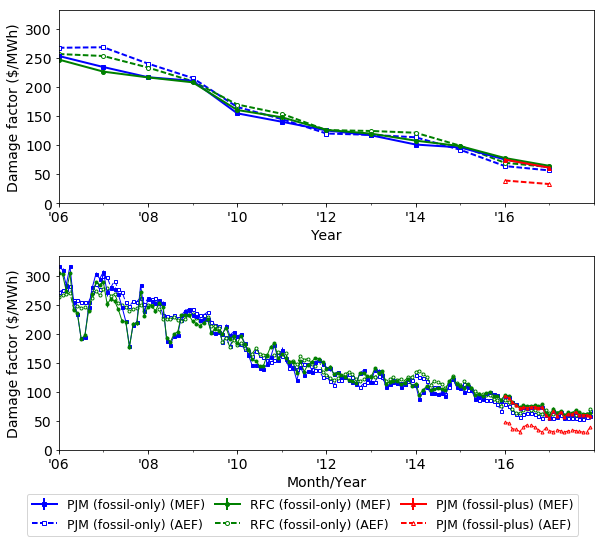

In [12]:
plot_over_time_annual_monthly('dam_ap2', all_dfs)

/Users/priyadonti/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


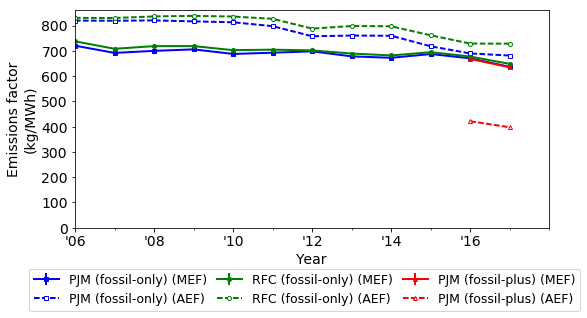

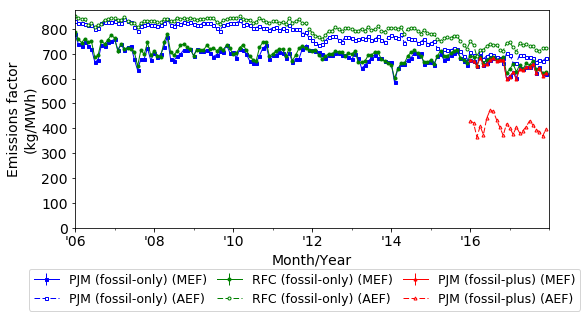

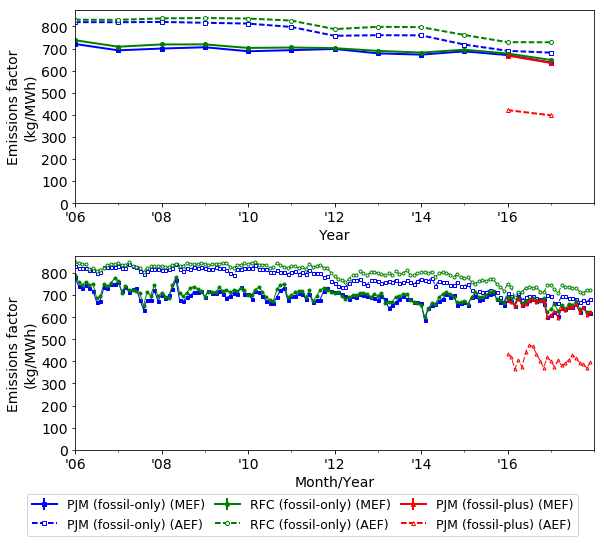

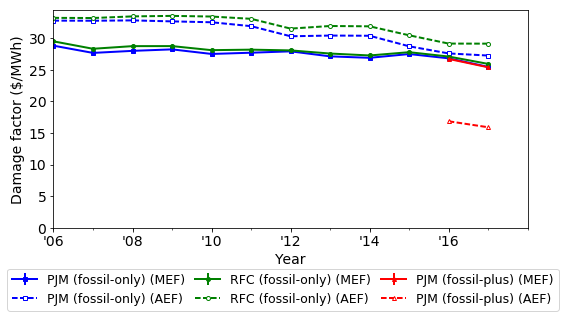

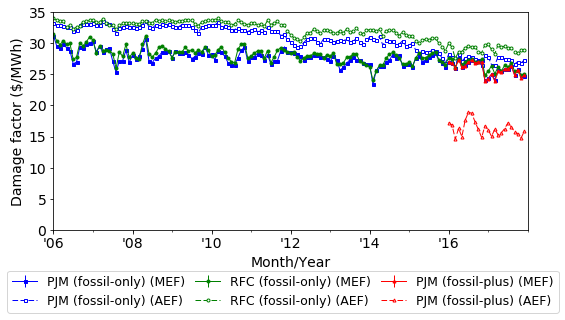

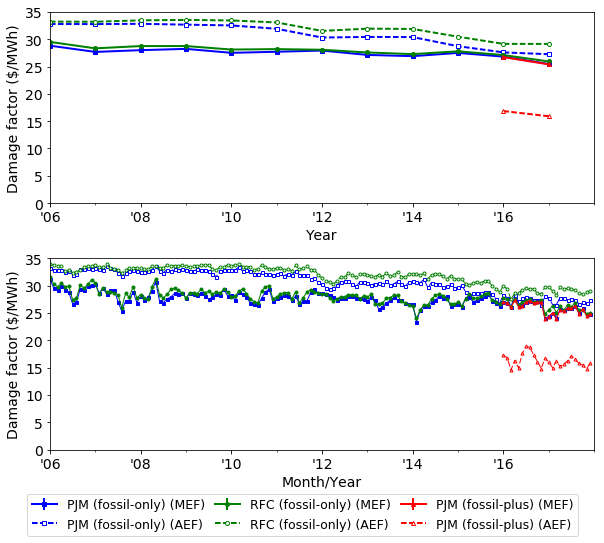

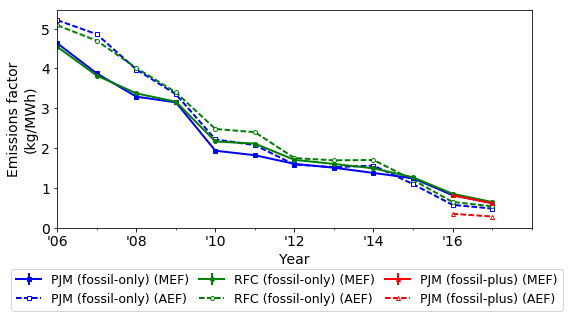

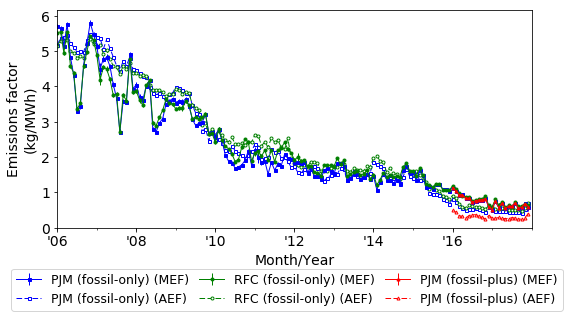

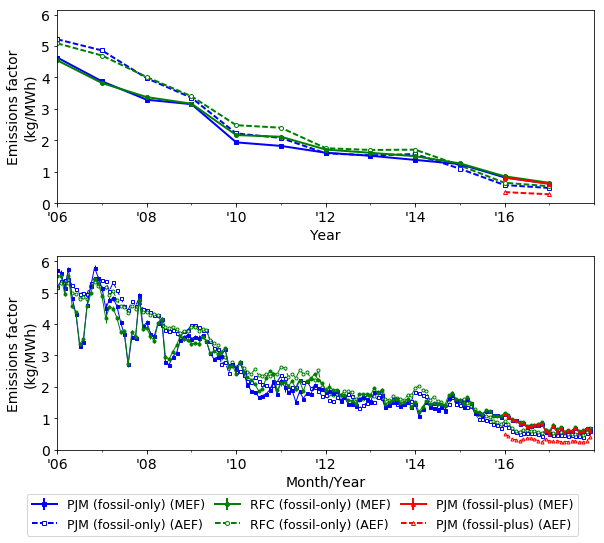

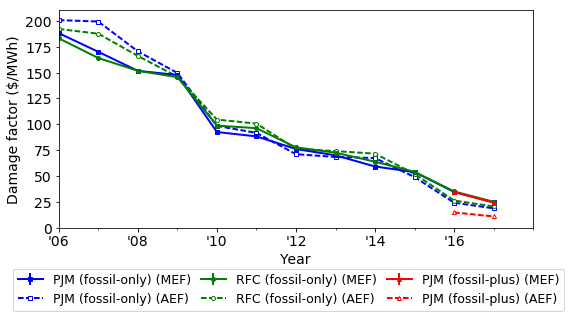

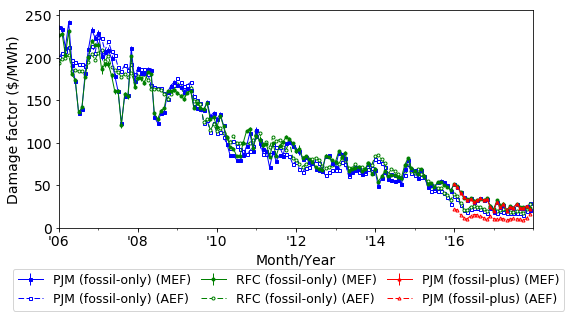

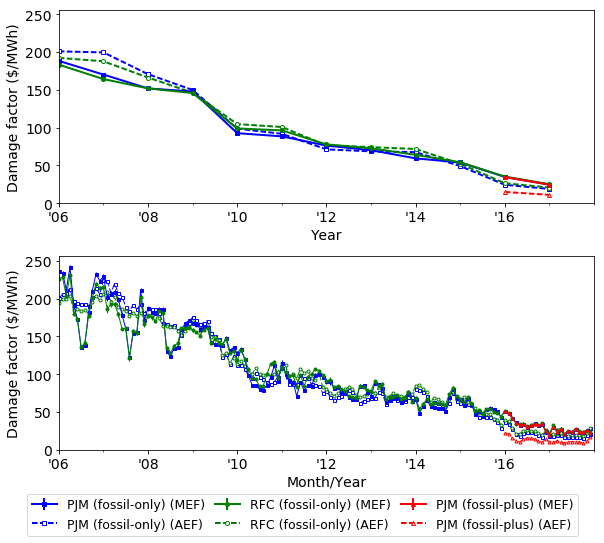

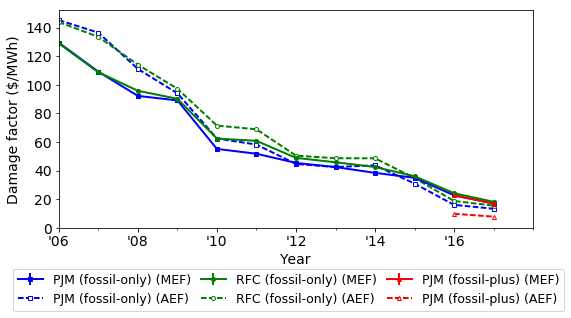

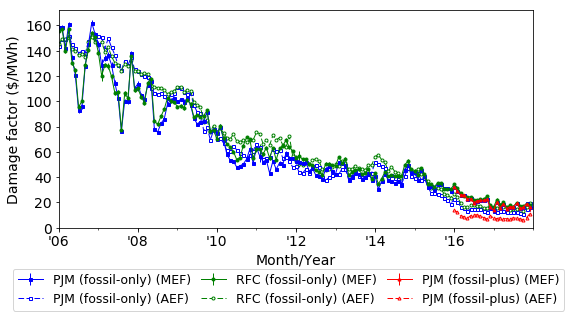

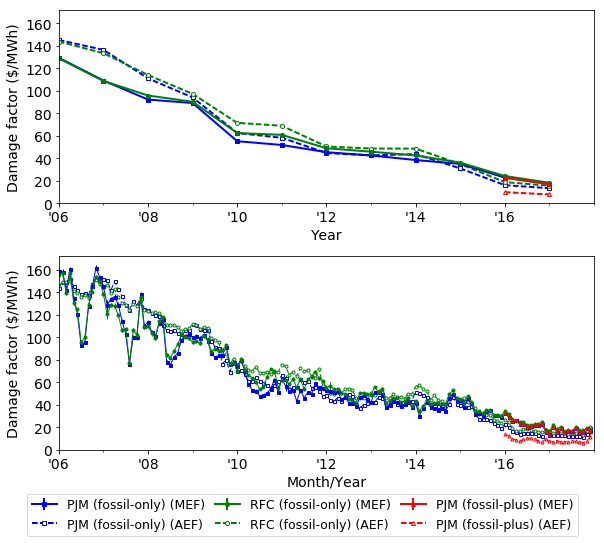

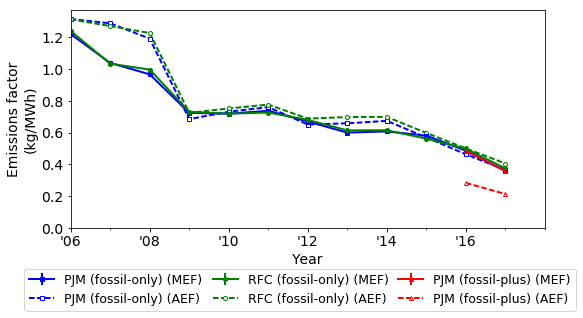

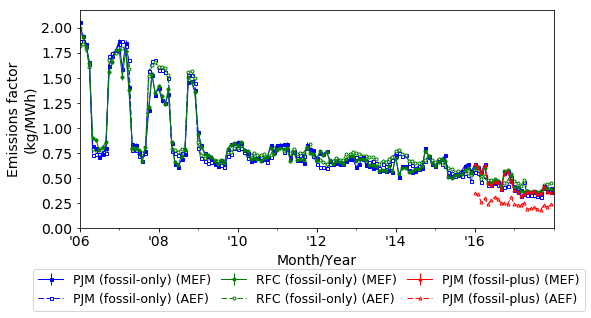

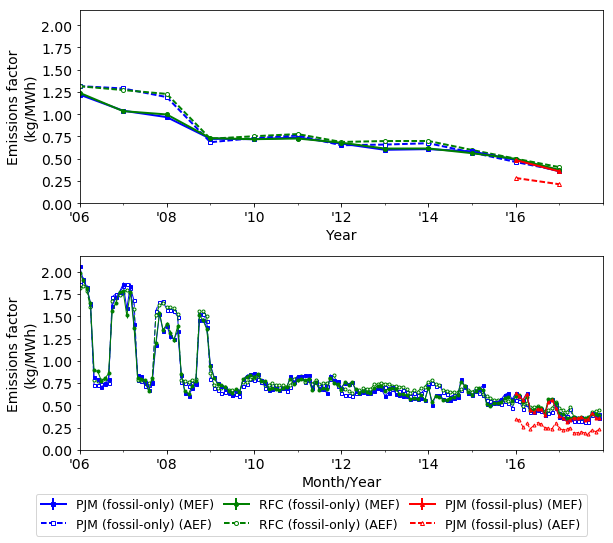

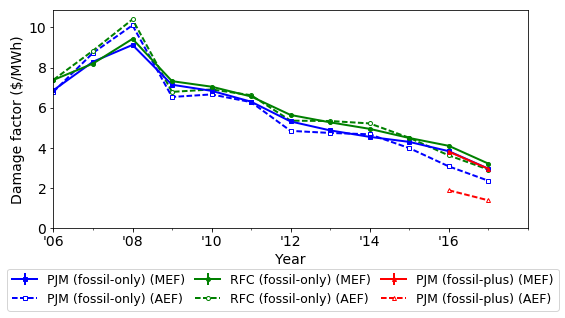

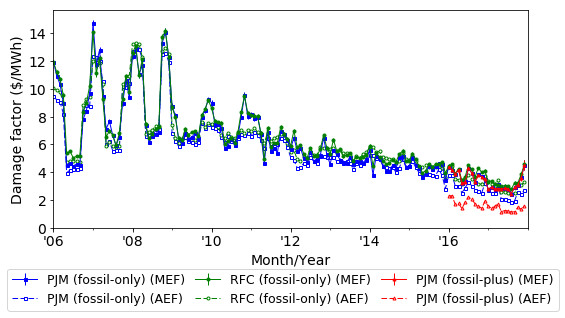

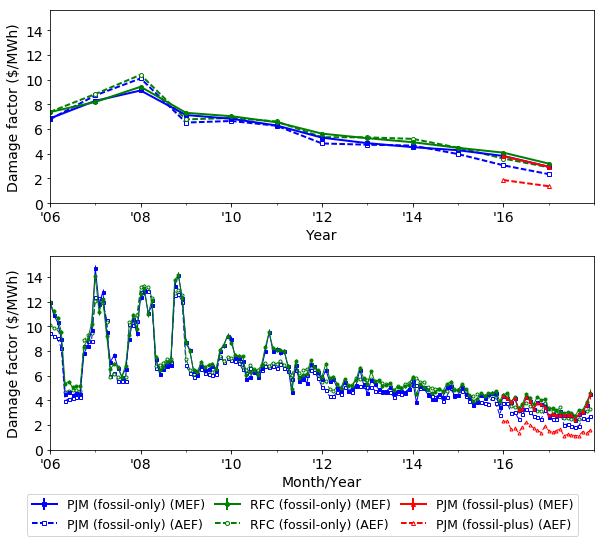

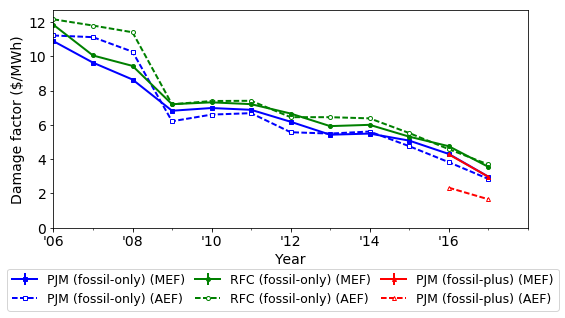

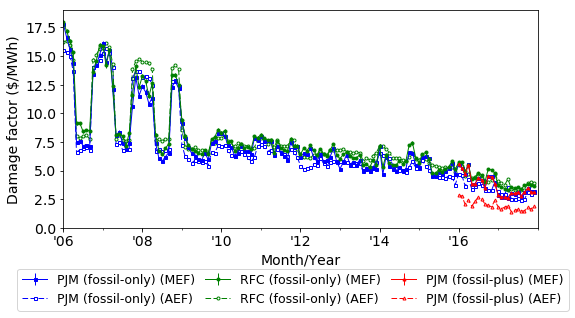

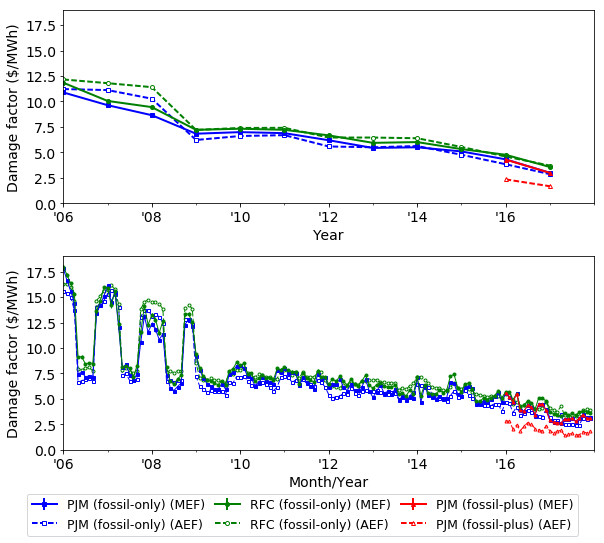

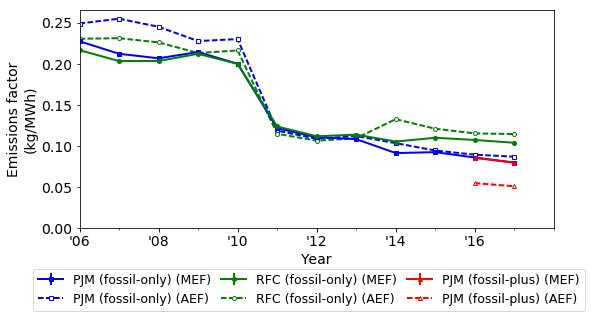

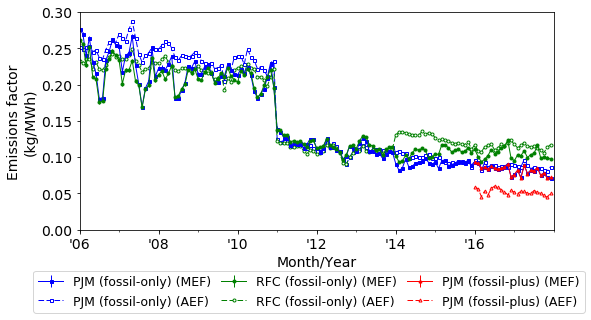

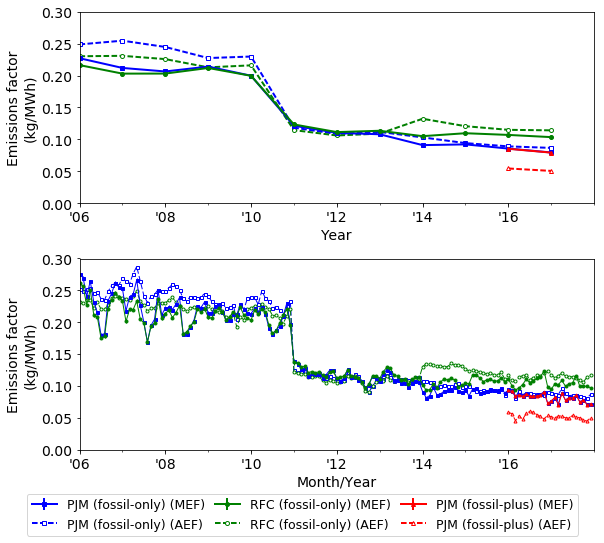

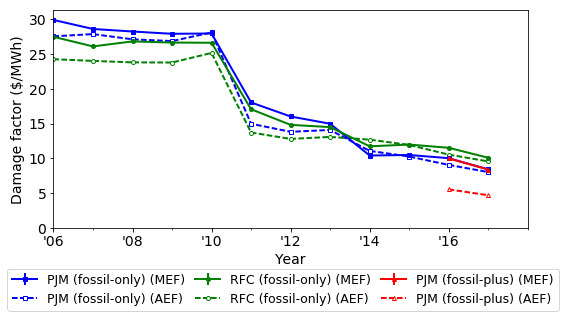

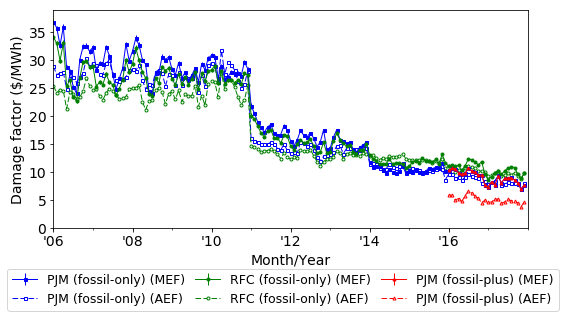

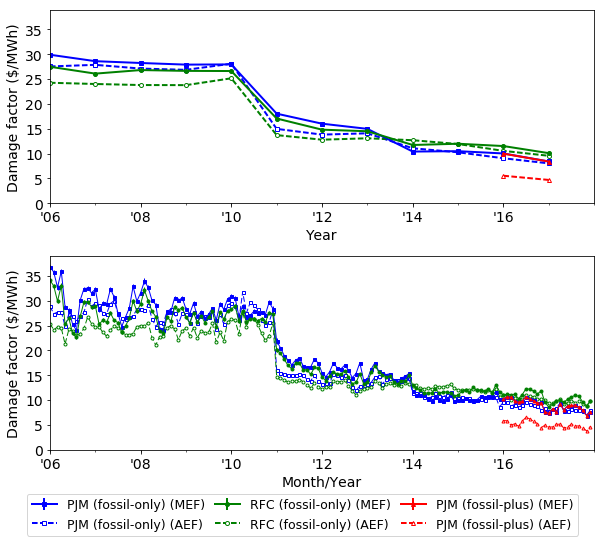

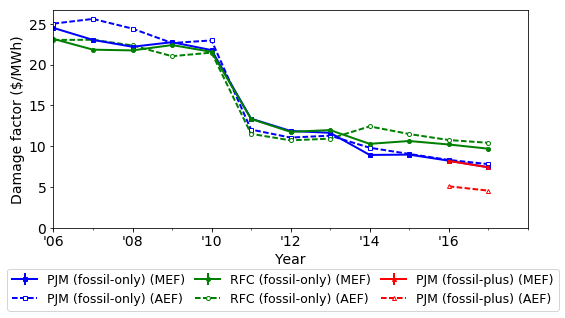

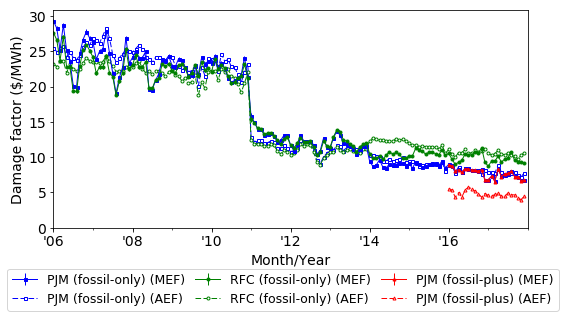

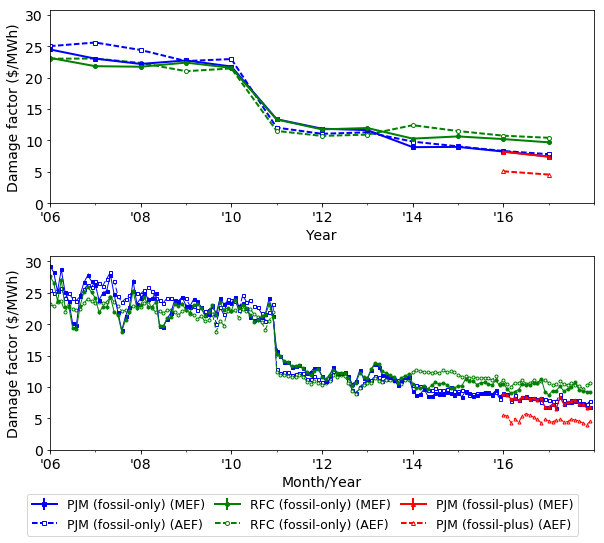

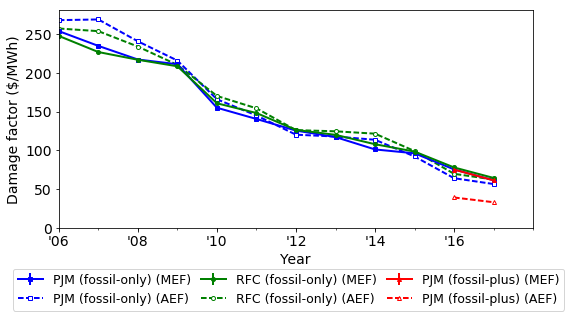

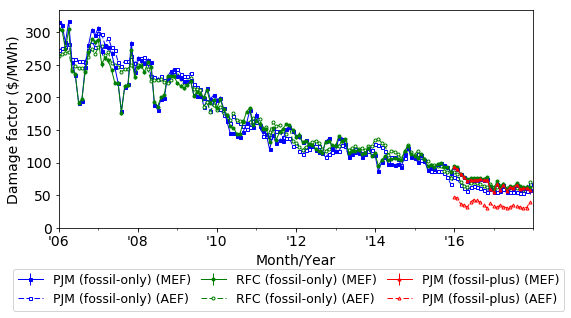

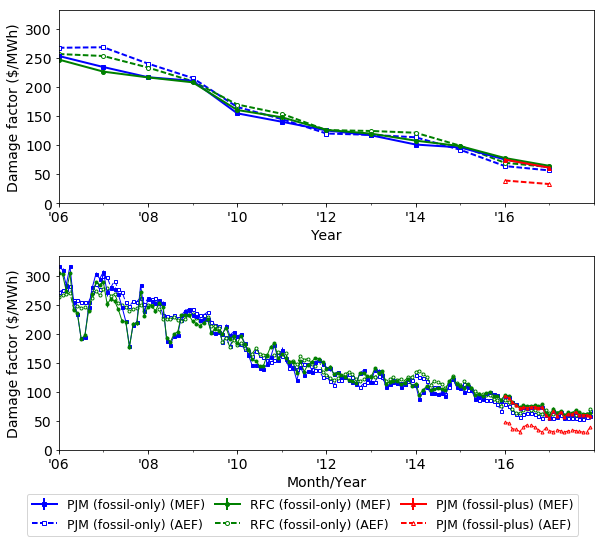

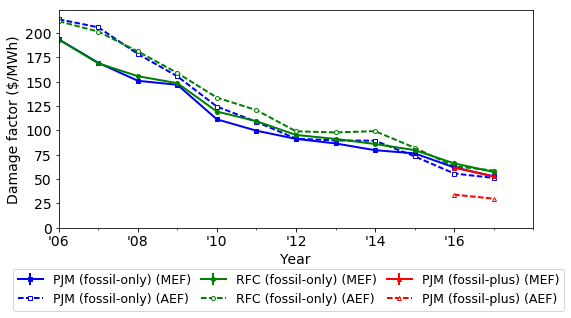

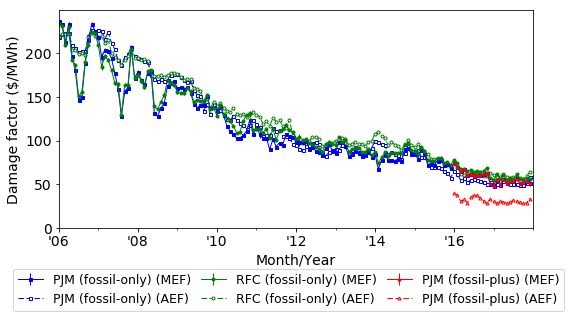

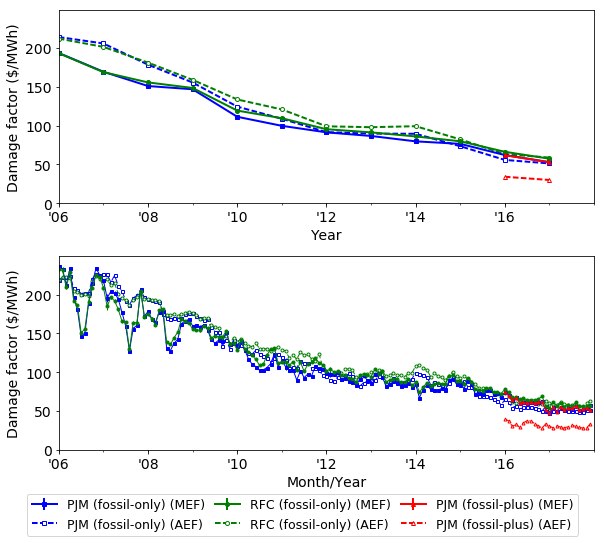

In [13]:
for label in LABELS_FULL:
    plot_over_time_annual(label, all_dfs)
    plot_over_time_monthly(label, all_dfs)
    plot_over_time_annual_monthly(label, all_dfs)

## Stats 

In [14]:
from IPython.core.display import display
from IPython.core.debugger import set_trace
from functools import reduce

In [15]:
col_groups = [
    ['ap2', ('dam_ap2',)],
    ['eas', ('dam_eas',)],
    ['co2', ('co2_kg',)],# 'co2_dam')],  # comparisons are same for co2_kg and co2_dam since related by constant factor
    ['so2', ('so2_kg', 'so2_dam_ap2', 'so2_dam_eas')],
    ['nox', ('nox_kg', 'nox_dam_ap2', 'nox_dam_eas')],
    ['pm25', ('pm25_kg', 'pm25_dam_ap2', 'pm25_dam_eas')]
]

col_order_flattened = reduce(lambda x,y: x + y, list(zip(*col_groups))[1])
col_groups_alone = list(zip(col_order_flattened, col_order_flattened))

In [16]:
def get_pdiff(df1, df2):
    return 100 * (df1 - df2)/df2

In [17]:
def get_ranges(df, col_groups, comparison, period, append=None, dims=1, rounding=0):
    if dims == 1:
        ranges = get_ranges_1d(df, col_groups, rounding)
    else:
        ranges = get_ranges_2d(df, col_groups, rounding)
    
    ranges_df = pd.DataFrame.from_dict(ranges, orient='index').T
    ranges_df.index = pd.MultiIndex.from_tuples([(comparison, period)], names=['Comparison', 'Period'])
    ranges_df = ranges_df[list(list(zip(*col_groups))[0])]  # col order
    if append: ranges_df = ranges_df.applymap(lambda x: '{} {}'.format(x, append))
    return ranges_df

In [18]:
def get_ranges_1d(df, col_groups, rounding):
    ranges = {}
    for header, labels in col_groups:
        if len(labels) == 1:
            df2 = pd.DataFrame(df).query('index in @labels')
            if rounding == 0:
                ranges[header] = '{}'.format(df2.round(0).astype(int).values[0][0])
            else:
                ranges[header] = '{}'.format(df2.round(rounding).values[0][0])
        else:
            df2 = pd.DataFrame(df).query('index in @labels')
            if rounding == 0:
                min_val = df2.min().apply(np.floor).astype(int).values[0]
                max_val = df2.max().apply(np.ceil).astype(int).values[0]
            else:
                min_val = df2.min().round(rounding).values[0]
                max_val = df2.max().round(rounding).values[0]
            ranges[header] = '{} to {}'.format(min_val, max_val)
    return ranges

In [19]:
def get_ranges_2d(df, col_groups, rounding):
    ranges = {}
    for header, labels in col_groups:
        df2 = pd.DataFrame(df).query('index in @labels')
        if rounding == 0:
            min_val = int(np.floor(df2.min().min()))
            max_val = int(np.ceil(df2.max().max()))
        else:
            min_val = df2.min().min().round(rounding)
            max_val = df2.max().max().round(rounding)
        ranges[header] = '{} to {}'.format(min_val, max_val)
    return ranges

### Percent decrease over time

#### PJM fossil-only, 2006-2017 

In [20]:
l = []
for kind in ['MEF', 'AEF']:
    df = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')]
    pct_change = -get_pdiff(df.loc[2017], df.loc[2006])
    l.append(get_ranges(pct_change, col_groups, 
                        '% decrease over time (annual factors, PJM fossil-only)', '2006-2017', 
                        append='({})'.format(kind[0])))
dec_2006_2017 = l[0] + '\\\\' + l[1]
dec_2006_2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"% decrease over time (annual factors, PJM fossil-only)",2006-2017,76 (M)\\79 (A),73 (M)\\76 (A),12 (M)\\17 (A),86 to 87 (M)\\90 to 91 (A),57 to 73 (M)\\65 to 75 (A),65 to 72 (M)\\65 to 71 (A)


####  PJM fossil-only, 2016-2017

In [21]:
l = []
for kind in ['MEF', 'AEF']:
    df = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')]
    pct_change = -get_pdiff(df.loc[2017], df.loc[2016])
    l.append(get_ranges(pct_change, col_groups, 
                        '% decrease over time (annual factors, PJM fossil-only)', '2016-2017', 
                        append='({})'.format(kind[0])))
dec_2016_2017 = l[0] + '\\\\' + l[1]
dec_2016_2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"% decrease over time (annual factors, PJM fossil-only)",2016-2017,19 (M)\\12 (A),15 (M)\\8 (A),5 (M)\\1 (A),24 to 30 (M)\\16 to 23 (A),22 to 31 (M)\\21 to 26 (A),7 to 17 (M)\\2 to 12 (A)


####  PJM fossil-plus, 2016-2017

In [22]:
l = []
for kind in ['MEF', 'AEF']:
    df = all_dfs[(kind, 'PJM', 'FossilPlus', 'YearOnly')]
    pct_change = -get_pdiff(df.loc[2017], df.loc[2016])
    l.append(get_ranges(pct_change, col_groups, 
                        '% decrease over time (annual factors, PJM fossil-plus)', '2016-2017', 
                        append='({})'.format(kind[0])))
dec_fplus_2016_2017 = l[0] + '\\\\' + l[1]
dec_fplus_2016_2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"% decrease over time (annual factors, PJM fossil-plus)",2016-2017,18 (M)\\16 (A),15 (M)\\12 (A),5 (M)\\6 (A),24 to 30 (M)\\19 to 26 (A),22 to 31 (M)\\24 to 29 (A),7 to 16 (M)\\7 to 16 (A)


### Average vs. marginal mean percent difference

#### Fossil-only, 2006-2017

In [23]:
marg = all_dfs[('MEF', 'PJM', 'FossilOnly', 'YearOnly')]
avg = all_dfs[('AEF', 'PJM', 'FossilOnly', 'YearOnly')]
pdiff = get_pdiff(avg, marg).mean()
avgmarg_fossil_allyears = get_ranges(pdiff, col_groups,
                                    'Average vs. marginal mean % difference (annual factors, PJM fossil-only)',
                                    '2006-2017') 
avgmarg_fossil_allyears

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Average vs. marginal mean % difference (annual factors, PJM fossil-only)",2006-2017,2,6,12,-1 to 4,-5 to 6,-6 to 9


#### Fossil-only 2014 

In [24]:
marg = all_dfs[('MEF', 'PJM', 'FossilOnly', 'YearOnly')].loc[2014]
avg = all_dfs[('AEF', 'PJM', 'FossilOnly', 'YearOnly')].loc[2014]
pdiff = get_pdiff(avg, marg)
avgmarg_fossil_2014 = get_ranges(pdiff, col_groups,
                                    'Average vs. marginal mean % difference (annual factors, PJM fossil-only)',
                                    '2014') 
avgmarg_fossil_2014

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Average vs. marginal mean % difference (annual factors, PJM fossil-only)",2014,12,12,13,13 to 14,2 to 11,6 to 14


#### Fossil-only 2015 

In [25]:
marg = all_dfs[('MEF', 'PJM', 'FossilOnly', 'YearOnly')].loc[2015]
avg = all_dfs[('AEF', 'PJM', 'FossilOnly', 'YearOnly')].loc[2015]
pdiff = get_pdiff(avg, marg)
avgmarg_fossil_2015 = get_ranges(pdiff, col_groups,
                                    'Average vs. marginal mean % difference (annual factors, PJM fossil-only)',
                                    '2015') 
avgmarg_fossil_2015

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Average vs. marginal mean % difference (annual factors, PJM fossil-only)",2015,-4,-4,4,-12 to -8,-8 to -1,-3 to 3


#### Fossil-only 2016 

In [26]:
marg = all_dfs[('MEF', 'PJM', 'FossilOnly', 'YearOnly')].loc[2016]
avg = all_dfs[('AEF', 'PJM', 'FossilOnly', 'YearOnly')].loc[2016]
pdiff = get_pdiff(avg, marg)
avgmarg_fossil_2016 = get_ranges(pdiff, col_groups,
                                    'Average vs. marginal mean % difference (annual factors, PJM fossil-only)',
                                    '2016') 
avgmarg_fossil_2016

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Average vs. marginal mean % difference (annual factors, PJM fossil-only)",2016,-15,-10,3,-31 to -29,-20 to -4,-10 to 5


#### Fossil-only, 2017

In [27]:
marg = all_dfs[('MEF', 'PJM', 'FossilOnly', 'YearOnly')].loc[2017]
avg = all_dfs[('AEF', 'PJM', 'FossilOnly', 'YearOnly')].loc[2017]
pdiff = get_pdiff(avg, marg)
avgmarg_fossil_2017 = get_ranges(pdiff, col_groups,
                                    'Average vs. marginal mean % difference (annual factors, PJM fossil-only)',
                                    '2017') 
avgmarg_fossil_2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Average vs. marginal mean % difference (annual factors, PJM fossil-only)",2017,-8,-3,7,-24 to -21,-21 to 2,-5 to 10


#### Fossil-plus, 2016

In [28]:
marg = all_dfs[('MEF', 'PJM', 'FossilPlus', 'YearOnly')].loc[2016]
avg = all_dfs[('AEF', 'PJM', 'FossilPlus', 'YearOnly')].loc[2016]
pdiff = get_pdiff(avg, marg)
avgmarg_fplus_2016 = get_ranges(pdiff, col_groups,
                                    'Average vs. marginal mean % difference (annual factors, PJM fossil-plus)',
                                    '2016') 
avgmarg_fplus_2016

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Average vs. marginal mean % difference (annual factors, PJM fossil-plus)",2016,-48,-45,-37,-58 to -56,-51 to -41,-45 to -36


#### Fossil-plus, 2017

In [29]:
marg = all_dfs[('MEF', 'PJM', 'FossilPlus', 'YearOnly')].loc[2017]
avg = all_dfs[('AEF', 'PJM', 'FossilPlus', 'YearOnly')].loc[2017]
pdiff = get_pdiff(avg, marg)
avgmarg_fplus_2017 = get_ranges(pdiff, col_groups,
                                    'Average vs. marginal mean % difference (annual factors, PJM fossil-plus)',
                                    '2017') 
avgmarg_fplus_2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Average vs. marginal mean % difference (annual factors, PJM fossil-plus)",2017,-46,-43,-37,-56 to -54,-54 to -40,-45 to -36


### RFC vs. PJM 

#### 2006-2017 

In [30]:
l = []
for kind in ['MEF', 'AEF']:
    rfc = all_dfs[(kind, 'RFC', 'FossilOnly', 'YearOnly')]
    pjm = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')]
    pdiff = get_pdiff(rfc, pjm).mean()
    l.append(get_ranges(pdiff, col_groups, 
                        'RFC vs. PJM % difference (annual factors, fossil-only)', '2006-2017', 
                        append='({})'.format(kind[0])))
rfc_pjm_allyears = l[0] + '\\\\' + l[1]
rfc_pjm_allyears

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"RFC vs. PJM % difference (annual factors, fossil-only)",2006-2017,2 (M)\\3 (A),5 (M)\\7 (A),2 (M)\\4 (A),2 to 7 (M)\\3 to 11 (A),1 to 9 (M)\\4 to 15 (A),1 to 8 (M)\\-2 to 7 (A)


In [31]:
l = []
for kind in ['MEF', 'AEF']:
    rfc = all_dfs[(kind, 'RFC', 'FossilOnly', 'YearOnly')]
    pjm = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')]
    pdiff = get_pdiff(rfc, pjm).mean()
    l.append(get_ranges(pdiff, col_groups_alone, 
                        'RFC vs. PJM % difference (annual factors, fossil-only)', '2006-2017', 
                        append='({})'.format(kind[0])))
rfc_pjm_allyears_expandgroups = l[0] + '\\\\' + l[1]
rfc_pjm_allyears_expandgroups

,,dam_ap2,dam_eas,co2_kg,so2_kg,so2_dam_ap2,so2_dam_eas,nox_kg,nox_dam_ap2,nox_dam_eas,pm25_kg,pm25_dam_ap2,pm25_dam_eas
Comparison,Period,,,,,,,,,,,,
"RFC vs. PJM % difference (annual factors, fossil-only)",2006-2017,1 to 2 (M)\\3 to 4 (A),4 to 5 (M)\\7 to 8 (A),1 to 2 (M)\\3 to 4 (A),4 to 5 (M)\\7 to 8 (A),2 to 3 (M)\\3 to 4 (A),6 to 7 (M)\\10 to 11 (A),1 to 2 (M)\\4 to 5 (A),5 to 6 (M)\\9 to 10 (A),8 to 9 (M)\\14 to 15 (A),7 to 8 (M)\\6 to 7 (A),1 to 2 (M)\\-2 to -1 (A),6 to 7 (M)\\5 to 6 (A)


#### 2017

In [32]:
l = []
for kind in ['MEF', 'AEF']:
    rfc = all_dfs[(kind, 'RFC', 'FossilOnly', 'YearOnly')].loc[2017]
    pjm = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')].loc[2017]
    pdiff = get_pdiff(rfc, pjm)
    l.append(get_ranges(pdiff, col_groups, 
                        'RFC vs. PJM % difference (annual factors, fossil-only)', '2017', 
                        append='({})'.format(kind[0])))
rfc_pjm_2017 = l[0] + '\\\\' + l[1]
rfc_pjm_2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"RFC vs. PJM % difference (annual factors, fossil-only)",2017,5 (M)\\10 (A),8 (M)\\15 (A),2 (M)\\7 (A),2 to 7 (M)\\9 to 17 (A),4 to 20 (M)\\11 to 30 (A),19 to 31 (M)\\19 to 34 (A)


In [33]:
l = []
for kind in ['MEF', 'AEF']:
    rfc = all_dfs[(kind, 'RFC', 'FossilOnly', 'YearOnly')].loc[2017]
    pjm = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')].loc[2017]
    pdiff = get_pdiff(rfc, pjm)
    l.append(get_ranges(pdiff, col_groups_alone, 
                        'RFC vs. PJM % difference (annual factors, fossil-only)', '2017', 
                        append='({})'.format(kind[0])))
rfc_pjm_allyears_expandgroups = l[0] + '\\\\' + l[1]
rfc_pjm_allyears_expandgroups

,,dam_ap2,dam_eas,co2_kg,so2_kg,so2_dam_ap2,so2_dam_eas,nox_kg,nox_dam_ap2,nox_dam_eas,pm25_kg,pm25_dam_ap2,pm25_dam_eas
Comparison,Period,,,,,,,,,,,,
"RFC vs. PJM % difference (annual factors, fossil-only)",2017,4 to 5 (M)\\10 to 11 (A),8 to 9 (M)\\14 to 15 (A),1 to 2 (M)\\6 to 7 (A),4 to 5 (M)\\11 to 12 (A),2 to 3 (M)\\9 to 10 (A),6 to 7 (M)\\16 to 17 (A),4 to 5 (M)\\11 to 12 (A),8 to 9 (M)\\23 to 24 (A),19 to 20 (M)\\29 to 30 (A),30 to 31 (M)\\31 to 32 (A),19 to 20 (M)\\19 to 20 (A),30 to 31 (M)\\33 to 34 (A)


### Monthly vs. annual

#### PJM fossil-only, 2006-2017 

In [34]:
l = []
for kind in ['MEF', 'AEF']:
    monthly = all_dfs[(kind, 'PJM', 'FossilOnly', 'Month')]
    
    # Give annual same index as monthly
    annual = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')]
    annual['month'] = 1
    annual = annual.reset_index().set_index(['year', 'month']).reindex(monthly.index).ffill()
    
    mapd = 100 * abs((monthly - annual)/annual)
    mapd2 = mapd.groupby(mapd.index.get_level_values('year')).mean()
    
    l.append(get_ranges(mapd2.T, col_groups, 
                        'Monthly vs. annual mean absolute % difference (PJM, fossil-only) (ranges are across years)', 
                        '2006-2017', 
                        append='({})'.format(kind[0]), dims=2))
ann_month_fossil_allyears = l[0] + '\\\\' + l[1]
ann_month_fossil_allyears

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Monthly vs. annual mean absolute % difference (PJM, fossil-only) (ranges are across years)",2006-2017,4 to 16 (M)\\3 to 12 (A),3 to 15 (M)\\2 to 11 (A),1 to 5 (M)\\0 to 2 (A),7 to 18 (M)\\2 to 23 (A),4 to 43 (M)\\3 to 39 (A),2 to 13 (M)\\1 to 8 (A)


#### PJM fossil-only, 2017

In [35]:
l = []
for kind in ['MEF', 'AEF']:
    monthly = all_dfs[(kind, 'PJM', 'FossilOnly', 'Month')].loc[2017]
    
    # Give annual same index as monthly
    annual = pd.DataFrame(all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')].loc[2017]).T
    annual.index = annual.index.map(lambda x: 1)
    annual.index.names = ['month']
    annual = annual.reindex(monthly.index).ffill()
    
    mapd = 100 * abs((monthly - annual)/annual).mean()
    
    l.append(get_ranges(mapd, col_groups, 
                        'Monthly vs. annual mean absolute % difference (PJM, fossil-only) (ranges are across years)', 
                        '2017', 
                        append='({})'.format(kind[0])))
ann_month_fossil_2017 = l[0] + '\\\\' + l[1]
ann_month_fossil_2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Monthly vs. annual mean absolute % difference (PJM, fossil-only) (ranges are across years)",2017,5 (M)\\4 (A),4 (M)\\3 (A),2 (M)\\2 (A),9 to 10 (M)\\9 to 11 (A),4 to 11 (M)\\10 to 15 (A),5 to 8 (M)\\2 to 5 (A)


#### PJM fossil-plus, 2016 

In [36]:
l = []
for kind in ['MEF', 'AEF']:
    monthly = all_dfs[(kind, 'PJM', 'FossilPlus', 'Month')].loc[2016]
    
    # Give annual same index as monthly
    annual = pd.DataFrame(all_dfs[(kind, 'PJM', 'FossilPlus', 'YearOnly')].loc[2016]).T
    annual.index = annual.index.map(lambda x: 1)
    annual.index.names = ['month']
    annual = annual.reindex(monthly.index).ffill()
    
    mapd = 100 * abs((monthly - annual)/annual).mean()
    
    l.append(get_ranges(mapd, col_groups, 
                        'Monthly vs. annual mean absolute % difference (PJM, fossil-plus) (ranges are across years)', 
                        '2016', 
                        append='({})'.format(kind[0])))
ann_month_fplus_2016 = l[0] + '\\\\' + l[1]
ann_month_fplus_2016

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Monthly vs. annual mean absolute % difference (PJM, fossil-plus) (ranges are across years)",2016,8 (M)\\11 (A),6 (M)\\9 (A),2 (M)\\6 (A),12 to 15 (M)\\13 to 19 (A),8 to 16 (M)\\11 to 15 (A),3 to 6 (M)\\6 to 10 (A)


#### PJM fossil-plus, 2017 

In [37]:
l = []
for kind in ['MEF', 'AEF']:
    monthly = all_dfs[(kind, 'PJM', 'FossilPlus', 'Month')].loc[2017]
    
    # Give annual same index as monthly
    annual = pd.DataFrame(all_dfs[(kind, 'PJM', 'FossilPlus', 'YearOnly')].loc[2017]).T
    annual.index = annual.index.map(lambda x: 1)
    annual.index.names = ['month']
    annual = annual.reindex(monthly.index).ffill()
    
    mapd = 100 * abs((monthly - annual)/annual).mean()
    
    l.append(get_ranges(mapd, col_groups, 
                        'Monthly vs. annual mean absolute % difference (PJM, fossil-plus) (ranges are across years)', 
                        '2017', 
                        append='({})'.format(kind[0])))
ann_month_fplus_2017 = l[0] + '\\\\' + l[1]
ann_month_fplus_2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
"Monthly vs. annual mean absolute % difference (PJM, fossil-plus) (ranges are across years)",2017,5 (M)\\5 (A),4 (M)\\4 (A),2 (M)\\3 (A),9 to 10 (M)\\9 to 11 (A),4 to 11 (M)\\8 to 13 (A),6 to 8 (M)\\3 to 6 (A)


### Fossil-only vs. fossil-plus

#### 2016 

In [38]:
l = []
for kind in ['MEF', 'AEF']:
    fossil = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')].loc[2016]
    fplus = all_dfs[(kind, 'PJM', 'FossilPlus', 'YearOnly')].loc[2016]
    pdiff = get_pdiff(fplus, fossil)
    l.append(get_ranges(pdiff, col_groups, 
                        'Fossil-plus vs. fossil-only % difference (annual factors)', '2016', 
                        append='({})'.format(kind[0])))
fossil_fplus_2016 = l[0] + '\\\\' + l[1]
fossil_fplus_2016

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
Fossil-plus vs. fossil-only % difference (annual factors),2016,0 (M)\\-39 (A),0 (M)\\-39 (A),0 (M)\\-39 (A),-1 to 0 (M)\\-39 to -38 (A),-1 to 0 (M)\\-39 to -38 (A),-1 to 0 (M)\\-39 to -38 (A)


In [39]:
l = []
for kind in ['MEF', 'AEF']:
    fossil = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')].loc[2016]
    fplus = all_dfs[(kind, 'PJM', 'FossilPlus', 'YearOnly')].loc[2016]
    pdiff = get_pdiff(fplus, fossil)
    l.append(get_ranges(pdiff, col_groups, 
                        'Fossil-plus vs. fossil-only % difference (annual factors)', '2016', 
                        append='({})'.format(kind[0]), rounding=2))
fossil_fplus_2016_decimal = l[0] + '\\\\' + l[1]
fossil_fplus_2016_decimal

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
Fossil-plus vs. fossil-only % difference (annual factors),2016,-0.38 (M)\\-38.92 (A),-0.37 (M)\\-38.92 (A),-0.36 (M)\\-38.92 (A),-0.38 to -0.35 (M)\\-38.92 to -38.92 (A),-0.54 to -0.52 (M)\\-38.92 to -38.92 (A),-0.38 to -0.37 (M)\\-38.92 to -38.92 (A)


In [40]:
l = []
for kind in ['MEF', 'AEF']:
    fossil = all_dfs[(kind, 'PJM', 'FossilOnly', 'Month')].loc[2016]
    fplus = all_dfs[(kind, 'PJM', 'FossilPlus', 'Month')].loc[2016]
    pdiff = get_pdiff(fplus, fossil).mean()
    l.append(get_ranges(pdiff, col_groups, 
                        'Fossil-plus vs. fossil-only % difference (monthly factors)', '2016', 
                        append='({})'.format(kind[0])))
fossil_fplus_month_2016 = l[0] + '\\\\' + l[1]
fossil_fplus_month_2016

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
Fossil-plus vs. fossil-only % difference (monthly factors),2016,0 (M)\\-39 (A),0 (M)\\-39 (A),0 (M)\\-39 (A),-1 to 0 (M)\\-40 to -39 (A),-1 to 0 (M)\\-40 to -39 (A),-1 to 0 (M)\\-40 to -39 (A)


#### 2017 

In [41]:
l = []
for kind in ['MEF', 'AEF']:
    fossil = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')].loc[2017]
    fplus = all_dfs[(kind, 'PJM', 'FossilPlus', 'YearOnly')].loc[2017]
    pdiff = get_pdiff(fplus, fossil)
    l.append(get_ranges(pdiff, col_groups, 
                        'Fossil-plus vs. fossil-only % difference (annual factors)', '2017', 
                        append='({})'.format(kind[0])))
fossil_fplus_2017 = l[0] + '\\\\' + l[1]
fossil_fplus_2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
Fossil-plus vs. fossil-only % difference (annual factors),2017,0 (M)\\-42 (A),0 (M)\\-42 (A),0 (M)\\-42 (A),-1 to 0 (M)\\-42 to -41 (A),-1 to 0 (M)\\-42 to -41 (A),-1 to 0 (M)\\-42 to -41 (A)


In [42]:
l = []
for kind in ['MEF', 'AEF']:
    fossil = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')].loc[2017]
    fplus = all_dfs[(kind, 'PJM', 'FossilPlus', 'YearOnly')].loc[2017]
    pdiff = get_pdiff(fplus, fossil)
    l.append(get_ranges(pdiff, col_groups, 
                        'Fossil-plus vs. fossil-only % difference (annual factors)', '2017', 
                        append='({})'.format(kind[0]), rounding=2))
fossil_fplus_2017_decimal = l[0] + '\\\\' + l[1]
fossil_fplus_2017_decimal

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
Fossil-plus vs. fossil-only % difference (annual factors),2017,-0.23 (M)\\-41.64 (A),-0.24 (M)\\-41.64 (A),-0.25 (M)\\-41.64 (A),-0.23 to -0.2 (M)\\-41.64 to -41.64 (A),-0.21 to -0.15 (M)\\-41.64 to -41.64 (A),-0.28 to -0.25 (M)\\-41.64 to -41.64 (A)


In [43]:
l = []
for kind in ['MEF', 'AEF']:
    fossil = all_dfs[(kind, 'PJM', 'FossilOnly', 'Month')].loc[2017]
    fplus = all_dfs[(kind, 'PJM', 'FossilPlus', 'Month')].loc[2017]
    pdiff = get_pdiff(fplus, fossil).mean()
    l.append(get_ranges(pdiff, col_groups, 
                        'Fossil-plus vs. fossil-only % difference (monthly factors)', '2017', 
                        append='({})'.format(kind[0])))
fossil_fplus_month_2017 = l[0] + '\\\\' + l[1]
fossil_fplus_month_2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
Fossil-plus vs. fossil-only % difference (monthly factors),2017,0 (M)\\-42 (A),0 (M)\\-42 (A),0 (M)\\-42 (A),-1 to 0 (M)\\-42 to -41 (A),-1 to 0 (M)\\-42 to -41 (A),-1 to 0 (M)\\-42 to -41 (A)


### Share in total over time 

#### 2017

In [44]:
l = []
title = 'Pollutant share in total damage factor (PJM annual fossil-only)'
year = 2017
fossil = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')].loc[year]
l.append(get_ranges(100 * fossil / fossil['dam_ap2'], 
           list(zip(['co2', 'so2', 'nox', 'pm25'], [(x,) for x in AP2_DAMS])), title, year, append='(AP2)'))
l.append(get_ranges(100 * fossil / fossil['dam_eas'], 
           list(zip(['co2', 'so2', 'nox', 'pm25'], [(x,) for x in EAS_DAMS])), title, year, append='(EAS)'))
dam_share2017 = l[0] + '\\\\' + l[1]
dam_share2017['ap2'] = '-'
dam_share2017['eas'] = '-'
dam_share2017 = dam_share2017[list(list(zip(*col_groups))[0])]
dam_share2017

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
Pollutant share in total damage factor (PJM annual fossil-only),2017,-,-,48 (AP2)\\53 (EAS),33 (AP2)\\26 (EAS),4 (AP2)\\6 (EAS),14 (AP2)\\15 (EAS)


#### 2006 

In [45]:
l = []
title = 'Pollutant share in total damage factor (PJM annual fossil-only)'
year = 2006
fossil = all_dfs[(kind, 'PJM', 'FossilOnly', 'YearOnly')].loc[year]
l.append(get_ranges(100 * fossil / fossil['dam_ap2'], 
           list(zip(['co2', 'so2', 'nox', 'pm25'], [(x,) for x in AP2_DAMS])), title, year, append='(AP2)'))
l.append(get_ranges(100 * fossil / fossil['dam_eas'], 
           list(zip(['co2', 'so2', 'nox', 'pm25'], [(x,) for x in EAS_DAMS])), title, year, append='(EAS)'))
dam_share2006 = l[0] + '\\\\' + l[1]
dam_share2006['ap2'] = '-'
dam_share2006['eas'] = '-'
dam_share2006 = dam_share2006[list(list(zip(*col_groups))[0])]
dam_share2006

,,ap2,eas,co2,so2,nox,pm25
Comparison,Period,,,,,,
Pollutant share in total damage factor (PJM annual fossil-only),2006,-,-,12 (AP2)\\15 (EAS),75 (AP2)\\68 (EAS),3 (AP2)\\5 (EAS),10 (AP2)\\12 (EAS)


### Construct table for paper 

In [46]:
table = pd.concat([dec_2006_2017, dec_2016_2017, dec_fplus_2016_2017,
                  avgmarg_fossil_allyears, avgmarg_fossil_2017, avgmarg_fplus_2016, avgmarg_fplus_2017,
                  rfc_pjm_allyears, rfc_pjm_2017,
                  ann_month_fossil_allyears, ann_month_fossil_2017, ann_month_fplus_2016, ann_month_fplus_2017,
                  fossil_fplus_2016, fossil_fplus_2017,
                  dam_share2006, dam_share2017])
table

ap2  \
Comparison                                         Period                                
% decrease over time (annual factors, PJM fossi... 2006-2017            76 (M)\\79 (A)   
                                                   2016-2017            19 (M)\\12 (A)   
% decrease over time (annual factors, PJM fossi... 2016-2017            18 (M)\\16 (A)   
Average vs. marginal mean % difference (annual ... 2006-2017                         2   
                                                   2017                             -8   
Average vs. marginal mean % difference (annual ... 2016                            -48   
                                                   2017                            -46   
RFC vs. PJM % difference (annual factors, fossi... 2006-2017              2 (M)\\3 (A)   
                                                   2017                  5 (M)\\10 (A)   
Monthly vs. annual mean absolute % difference (... 2006-2017  4 to 16 (M)\\3 to 12 (A)   
                                                   2017                   5 (M)\\4 (A)   
Monthly vs. annual mean absolute % difference (... 2016                  8 (M)\\11 (A)   
                                                   2017                   5 (M)\\5 (A)   
Fossil-plus vs. fossil-only % difference (annua... 2016                 0 (M)\\-39 (A)   
                                                   2017                 0 (M)\\-42 (A)   
Pollutant share in total damage factor (PJM ann... 2006                              -   
                                                   2017                              -   

                                                                                   eas  \
Comparison                                         Period                                
% decrease over time (annual factors, PJM fossi... 2006-2017            73 (M)\\76 (A)   
                                                   2016-2017             15 (M)\\8 (A)   
% decrease over time (annual factors, PJM fossi... 2016-2017            15 (M)\\12 (A)   
Average vs. marginal mean % difference (annual ... 2006-2017                         6   
                                                   2017                             -3   
Average vs. marginal mean % difference (annual ... 2016                            -45   
                                                   2017                            -43   
RFC vs. PJM % difference (annual factors, fossi... 2006-2017              5 (M)\\7 (A)   
                                                   2017                  8 (M)\\15 (A)   
Monthly vs. annual mean absolute % difference (... 2006-2017  3 to 15 (M)\\2 to 11 (A)   
                                                   2017                   4 (M)\\3 (A)   
Monthly vs. annual mean absolute % difference (... 2016                   6 (M)\\9 (A)   
                                                   2017                   4 (M)\\4 (A)   
Fossil-plus vs. fossil-only % difference (annua... 2016                 0 (M)\\-39 (A)   
                                                   2017                 0 (M)\\-42 (A)   
Pollutant share in total damage factor (PJM ann... 2006                              -   
                                                   2017                              -   

                                                                                 co2  \
Comparison                                         Period                              
% decrease over time (annual factors, PJM fossi... 2006-2017          12 (M)\\17 (A)   
                                                   2016-2017            5 (M)\\1 (A)   
% decrease over time (annual factors, PJM fossi... 2016-2017            5 (M)\\6 (A)   
Average vs. marginal mean % difference (annual ... 2006-2017                      12   
                                                   2017                            7   
Average vs. marginal mean % difference (annua

In [47]:
# Latex formatting, make easy to cut and paste

# Multi-line cells in latex
table = table.applymap(lambda x: '\\specialcell{{{0}}}'.format(x))

# No ellipses
pd.options.display.max_columns = 2000
pd.options.display.max_colwidth = 2000

# Easy formatting
table_str = table.to_latex().replace('\\textbackslash ', '\\').replace('\{', '{').replace('\}', '}')
print(table_str)

\begin{tabular}{llllllll}
\toprule
                                                                &      &                                     ap2 &                                     eas &                                   co2 &                                        so2 &                                        nox &                                       pm25 \\
Comparison & Period &                                         &                                         &                                       &                                            &                                            &                                            \\
\midrule
\% decrease over time (annual factors, PJM fossil-only) & 2006-2017 &            \specialcell{76 (M)\\79 (A)} &            \specialcell{73 (M)\\76 (A)} &          \specialcell{12 (M)\\17 (A)} &   \specialcell{86 to 87 (M)\\90 to 91 (A)} &   \specialcell{57 to 73 (M)\\65 to 75 (A)} &   \specialcell{65 to 72 (M)\\65 to 71 (A)} \\
           